In [ ]:
#import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import time


In [ ]:
#Settings
BATCH_SIZE = 64
NUM_EPOCHS = 20
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
#Prepare the Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               download=True,
                               transform=transform)

valid_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transform)

test_dataset = datasets.MNIST(root='./data',
                               train=False,
                               transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6003286.30it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 160850.48it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1492778.37it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8377541.23it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
validation_fraction = 0.1

num = int(validation_fraction * 60000)
train_indices = torch.arange(0, 60000 - num)
valid_indices = torch.arange(60000 - num, 60000)

In [ ]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          sampler=train_sampler)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=valid_sampler)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

In [ ]:
#Define the Model
class MLP(nn.Module):
  def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes):
    super().__init__()

    self.network = torch.nn.Sequential(
        #1st hidden layer
        torch.nn.Flatten(),
        torch.nn.Linear(num_features, num_hidden_1),
        torch.nn.BatchNorm1d(num_hidden_1),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        #2nd hidden layer
        torch.nn.Linear(num_hidden_1, num_hidden_2),
        torch.nn.BatchNorm1d(num_hidden_2),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.3),
        #output layer
        torch.nn.Linear(num_hidden_2, num_classes),
    )


  def forward(self, x):
    logits = self.network(x)
    return logits

In [ ]:
#Initiate Mode, Loss Function, Optimizer, and Schduler

model = MLP(num_features=28*28,
            num_hidden_1=128,
            num_hidden_2=64,
            num_classes=10)

model = model.to(DEVICE)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='min')

In [ ]:
#Training and Testing

def compute_accuracy(data_loader):

  with torch.no_grad():

    correct_pred, num_examples = 0, 0

    for i, (features, targets) in enumerate(data_loader):

      features = features.to(DEVICE)
      targets = targets.float().to(DEVICE)

      logits = model(features)
      _, predicted_labels = torch.max(logits,1)

      num_examples += targets.size(0)
      correct_pred += (predicted_labels == targets).sum()

    return correct_pred.float()/num_examples * 100

In [ ]:
start_time = time.time()
minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []


for epoch in range(NUM_EPOCHS):

  model.train()
  for batch_idx, (features, targets) in enumerate(train_loader):

      features = features.to(DEVICE)
      targets = targets.to(DEVICE)

      ## FORWARD AND BACK PROP
      logits = model(features)
      loss = criterion(logits, targets)
      optimizer.zero_grad()

      loss.backward()

      ## UPDATE MODEL PARAMETERS
      optimizer.step()


      ## LOGGING
      minibatch_loss_list.append(loss.item())
      logging_interval = 100
      if not batch_idx % logging_interval:
        print("Epoch: ", epoch+1, "/", NUM_EPOCHS, "| Batch ", batch_idx, "/", len(train_loader), f'| Loss: {loss:.4f}')



  model.eval()
  with torch.no_grad(): #save memory during interface
    train_acc = compute_accuracy(train_loader)
    valid_acc = compute_accuracy(valid_loader)
    print("Epoch: ", epoch+1, "/", NUM_EPOCHS, f'| Train: {train_acc :.2f}% '
                                               f'| Validation: {valid_acc :.2f}% ' )

    train_acc_list.append(train_acc.item())
    valid_acc_list.append(valid_acc.item())

    elapsed = (time.time() - start_time)/60
    print("Time elapsed: ",elapsed, " min")


    scheduler.step(minibatch_loss_list[-1])


    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc = compute_accuracy(test_loader)
    print(f'Test accuracy: {test_acc:.2f}%')

Epoch:  1 / 20 | Batch  0 / 843 | Loss: 2.4521
Epoch:  1 / 20 | Batch  100 / 843 | Loss: 0.6199
Epoch:  1 / 20 | Batch  200 / 843 | Loss: 0.4599
Epoch:  1 / 20 | Batch  300 / 843 | Loss: 0.3648
Epoch:  1 / 20 | Batch  400 / 843 | Loss: 0.4375
Epoch:  1 / 20 | Batch  500 / 843 | Loss: 0.5042
Epoch:  1 / 20 | Batch  600 / 843 | Loss: 0.3727
Epoch:  1 / 20 | Batch  700 / 843 | Loss: 0.5075
Epoch:  1 / 20 | Batch  800 / 843 | Loss: 0.1122
Epoch:  1 / 20 | Train: 94.94% | Validation: 96.32% 
Time elapsed:  0.6007593512535095  min
Total Training Time: 0.60 min
Test accuracy: 94.96%
Epoch:  2 / 20 | Batch  0 / 843 | Loss: 0.2866
Epoch:  2 / 20 | Batch  100 / 843 | Loss: 0.5515
Epoch:  2 / 20 | Batch  200 / 843 | Loss: 0.3326
Epoch:  2 / 20 | Batch  300 / 843 | Loss: 0.2570
Epoch:  2 / 20 | Batch  400 / 843 | Loss: 0.4151
Epoch:  2 / 20 | Batch  500 / 843 | Loss: 0.1705
Epoch:  2 / 20 | Batch  600 / 843 | Loss: 0.3053
Epoch:  2 / 20 | Batch  700 / 843 | Loss: 0.4060
Epoch:  2 / 20 | Batch  800

Text(0, 0.5, 'Loss')

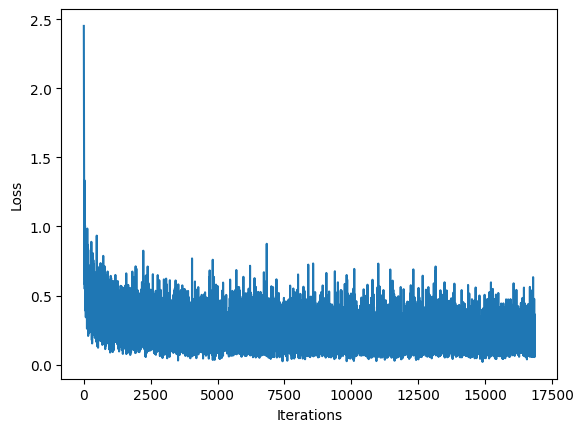

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(minibatch_loss_list)), minibatch_loss_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')


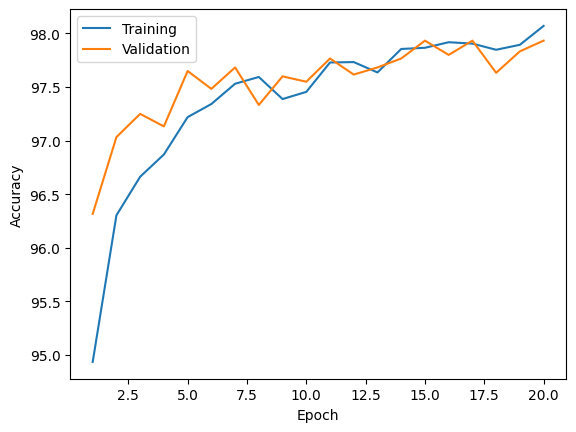

In [ ]:
import numpy as np
num_epochs = len(train_acc_list)
plt.plot(np.arange(1, num_epochs+1),
train_acc_list, label='Training')
plt.plot(np.arange(1, num_epochs+1),
valid_acc_list, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()